In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [7]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, sparse=None, rho=1., optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self.sparse = sparse
        self.rho = rho
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        
        if self.sparse == 'KL':
            self.latent_fn = nn.Sigmoid()
        else:
            self.latent_fn = nn.Tanh()
            
        self.fce = FullyConnected([32*2*2, 32])
        self.fcd = FullyConnected([32, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.latent_fn(self.fce(flatten))
        return h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
        
    def forward(self, x):
        self.h = self.encode(x)
        x = self.decode(self.h)
        return x
    
    def loss(self, output, target):
        if self.sparse == 'KL':
            h_mean = self.h.mean(0)
            sparse_loss = - torch.log(h_mean) * self.rho - torch.log(1-h_mean) * (1-self.rho)
            self.sparse_loss = sparse_loss.mean()
        elif self.sparse == 'L1':
            h_abs = torch.abs(self.h.mean(0))
            self.sparse_loss = self.rho*h_abs.mean()
        else:
            self.sparse_loss = 0.
            
        self._loss = F.mse_loss(output, target) + self.sparse_loss
        
        return self._loss

In [8]:
# models = {'SGD': Net(False, False, 'SGD', lr=1e-4),
#           'momentum': Net(False, False, 'SGD', lr=1e-4, momentum=0.9),
#           'RMSProp': Net(False, False, 'RMSProp', lr=1e-4),
#           'RMSProp+bn': Net(True, False, 'RMSProp', lr=1e-4),
#           'Adam': Net(False, False, 'Adam', lr=1e-4), 
#           'Adam+bn': Net(True, False, 'Adam', lr=1e-4), 
#          }

models = {'Adam KL': Net(False, False, sparse='KL', rho=0.1, optim_type='Adam', lr=1e-4),
          'Adam L1': Net(False, False, sparse='L1', rho=0.1, optim_type='Adam', lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [9]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [10]:
def test(models, loader, log=None):
    test_size = len(loader)
    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data).item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}'.format(k, test_loss[k]) for k in test_loss])
    if log is not None:
        for k in models:
            log[k].append((test_loss[k],))
    print(report)

In [11]:
for epoch in range(1, 11):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses Adam KL: 0.8045 Adam L1: 0.1265
Train Epoch: 1 [10000/50000 (20%)]	Losses Adam KL: 0.4041 Adam L1: 0.0756
Train Epoch: 1 [20000/50000 (40%)]	Losses Adam KL: 0.3938 Adam L1: 0.0622
Train Epoch: 1 [30000/50000 (60%)]	Losses Adam KL: 0.3872 Adam L1: 0.0523
Train Epoch: 1 [40000/50000 (80%)]	Losses Adam KL: 0.3920 Adam L1: 0.0500
Train Epoch: 1 [50000/50000 (100%)]	Losses Adam KL: 0.3891 Adam L1: 0.0454
Test losses: Adam KL: 0.3878 Adam L1: 0.0439
Train Epoch: 2 [0/50000 (0%)]	Losses Adam KL: 0.3891 Adam L1: 0.0439
Train Epoch: 2 [10000/50000 (20%)]	Losses Adam KL: 0.3899 Adam L1: 0.0410
Train Epoch: 2 [20000/50000 (40%)]	Losses Adam KL: 0.3830 Adam L1: 0.0356
Train Epoch: 2 [30000/50000 (60%)]	Losses Adam KL: 0.3803 Adam L1: 0.0333
Train Epoch: 2 [40000/50000 (80%)]	Losses Adam KL: 0.3775 Adam L1: 0.0339
Train Epoch: 2 [50000/50000 (100%)]	Losses Adam KL: 0.3761 Adam L1: 0.0300
Test losses: Adam KL: 0.3757 Adam L1: 0.0304
Train Epoch: 3 [0/50000 (0%)]	

In [12]:
data, _ = next(iter(test_loader))
output = models['Adam KL'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['Adam KL'].decode(torch.eye(32))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['Adam KL'].encode(data)
    print((encoded > 0.12).sum(1))
    encoded[encoded < 0.12] = 0.
    decoded_f = models['Adam KL'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 12,  11,  21,   6,   9,  18,  11,  14,  10,   6,  10,  10,
          9,   7,  16,  13,   4,  11,  11,  11,  10,   8,  11,   5,
         16,   4,  13,  11,   8,  16,  12,  15,  12,  13,   7,   7,
         10,  16,  10,  11,  21,  12,  10,  12,  12,   9,  10,  12,
          6,  11])


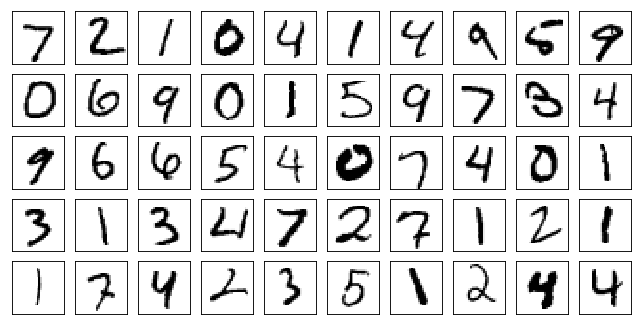

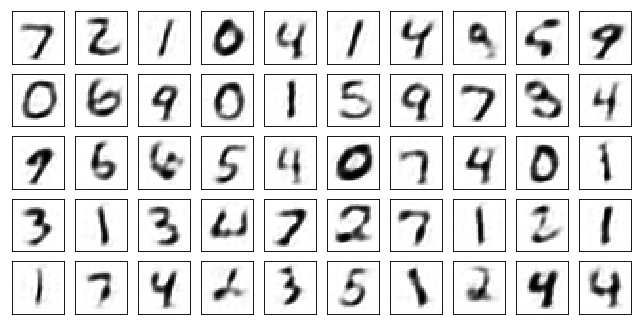

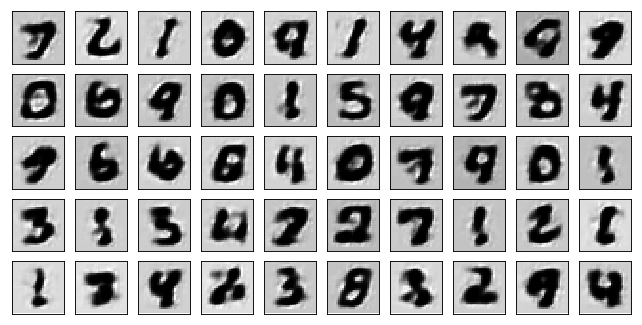

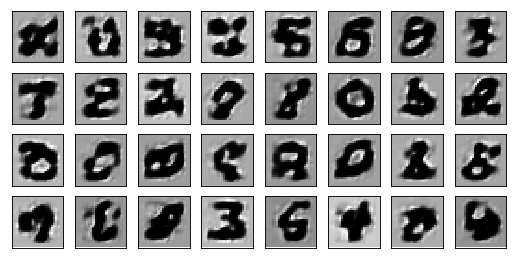

In [13]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8)) 

In [20]:
output = models['Adam L1'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['Adam L1'].decode(torch.eye(32))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['Adam L1'].encode(data)
    print((np.abs(encoded) > 0.1).sum(1))
    encoded[np.abs(encoded) < 0.1] = 0.
    decoded_f = models['Adam L1'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([  9,  12,   6,  14,  11,   6,  13,  15,  16,  12,  13,   9,
          7,  11,   9,  12,  10,   9,  17,   4,  12,   8,  13,   8,
          6,  17,   8,  11,  12,   9,  11,  11,  16,  14,   7,  13,
         14,   9,  10,  10,   7,   9,  11,  10,  10,   9,  12,   7,
         13,  13])


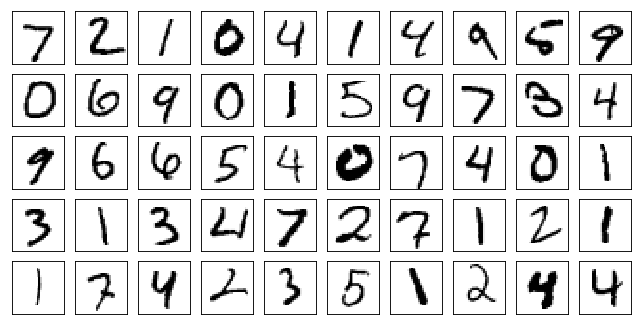

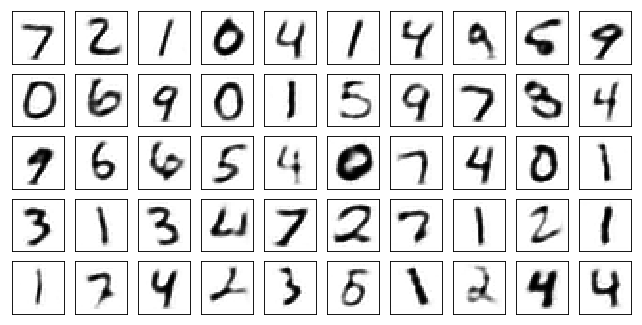

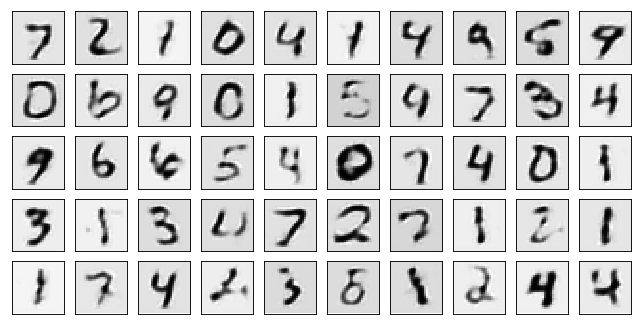

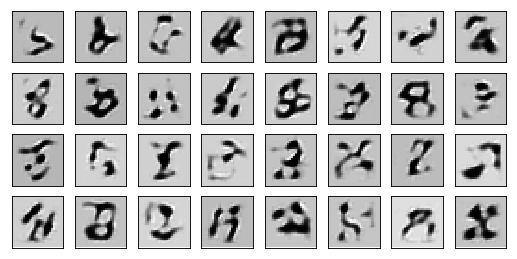

In [21]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8)) 